In [1]:
import os
import re
import logging
from pathlib import Path
from typing import Any, Pattern
from fastai.vision.all import *

In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class DirectoryUtil:
    """Utility class for handling directories."""

    @staticmethod
    def directory_exists(path: str) -> bool:
        """
        Checks if the specified directory exists.
        
        Args:
            path (str): The directory path.
        
        Returns:
            bool: True if the directory exists, False otherwise.
        """
        return os.path.isdir(s=path)

    @staticmethod
    def create_directory(path: str) -> None:
        """
        Creates a directory at the specified path.
        If the directory already exists, no exception is raised.
        
        Args:
            path (str): The directory path.
        """
        try:
            os.makedirs(name=path, exist_ok=True)
            logging.info(msg=f"Directory created: {path}")
        except Exception as e:
            logging.info(msg=f"Error creating directory {path}: {e}")

    @staticmethod
    def ensure_directory(path: str) -> str:
        """
        Ensures that the directory exists. If it does not, the directory is created.
        
        Args:
            path (str): The directory path.

        Return:
            str: Directory path.
        """
        if not DirectoryUtil.directory_exists(path):
            DirectoryUtil.create_directory(path)
            return path
        else:
            logging.info(msg=f"Directory already exists: {path}")
            return path

    @staticmethod
    def find_downloaded_dataset(datasets_path: str, project_id: str, version_number: int) -> str:
        # logging.info(f"Directories in '{datasets_path}': {os.listdir(datasets_path)}")

        expected_name: str = f"{project_id}-{version_number}"
        pattern: Pattern[str] = re.compile(re.escape(pattern=expected_name), re.IGNORECASE)

        for folder in os.listdir(path=datasets_path):
            folder_path: str = os.path.join(datasets_path, folder)

            # logging.info(f"Comparing: '{folder}' vs '{expected_name}'")

            if os.path.isdir(s=folder_path) and pattern.search(string=folder):
                return folder_path 

        logging.error(msg=f"Dataset not found for: '{project_id}-{version_number}' in '{datasets_path}'.")
        raise FileNotFoundError(f"Dataset not found for: '{project_id}-{version_number}' in '{datasets_path}'.")

In [3]:
class ResNet:
    def __init__(self, data_path: Path, model_id: str)-> None:
        self.data_path = data_path
        self.model_id = model_id
        self.data = None
        self.learn = None

    def load_data(self, bs: int = 64, size: int = 299, tfms: list = [])-> None:
        files: list[Any] = []
        classes: list[Any] = []
        for subdir in self.data_path.iterdir():
            for fn in subdir.glob(pattern='*.png'):
                files.append(fn)
                classes.append(subdir.name)

        self.data = ImageDataLoaders.from_lists(path=self.data_path,fnames=files, labels=classes, bs=bs, item_tfms=tfms, size=size) 
        logging.info(msg=f"Data loaded: {self.data}")

    def get_classes(self) -> None:
        if self.data is None:
            logging.error(msg="Data is not loaded. Run load_data() first")
            raise ValueError("Data is not loaded. Run load_data() first")

        logging.info(msg=f"{len(self.data.vocab)}, {self.data.vocab})")

    def show_batch(self) -> None:
        if self.data is None:
            logging.error(msg="Data is not loaded. Run load_data() first")
            raise ValueError("Data is not loaded. Run load_data() first")

        self.data.show_batch()

    def train(self) -> None:
        if self.data is None:
            logging.error(msg="Data is not loaded. Run load_data() first")
            raise ValueError("Data is not loaded. Run load_data() first")

        learn: Learner = vision_learner(dls=self.data, arch=models.resnet50, metrics=error_rate)
        learn.fine_tune(6)
        learn.save(f"{self.model_id}-stage-1")
        self.learn = learn

    def view_results(self) -> None:
        if self.learn is None:
            logging.error(msg="Learner is not trained. Run train() first")
            raise ValueError("Learner is not trained. Run train() first")

        interp = ClassificationInterpretation.from_learner(self.learn)
        interp.plot_confusion_matrix(figsize=(6,6), dpi=60)


In [4]:
DATA_PATH: str = '/root/work/data/renders'

In [5]:
data_path: str = DirectoryUtil.ensure_directory(path=DATA_PATH)

2025-03-21 07:29:03,854 - INFO - Directory already exists: /root/work/data/renders


In [6]:
resNet: ResNet = ResNet(data_path=Path(data_path), model_id='resnet34')

In [7]:
resNet.load_data()

2025-03-21 07:30:49,105 - INFO - Data loaded: <fastai.data.core.DataLoaders object at 0x7f782fc7e950>


In [8]:
resNet.get_classes()

2025-03-21 07:30:49,155 - INFO - 2, ['c', 'cpp'])


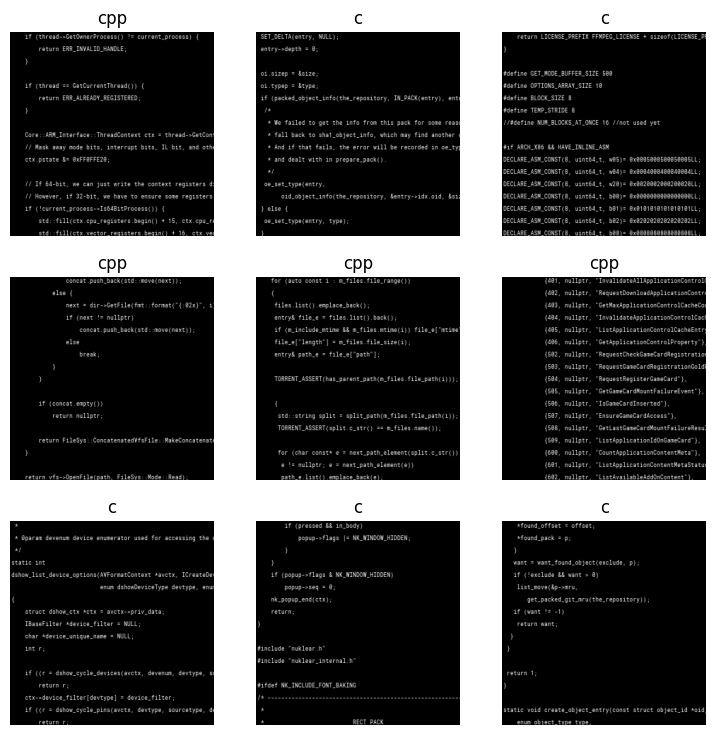

In [9]:
resNet.show_batch()

In [10]:
resNet.train()

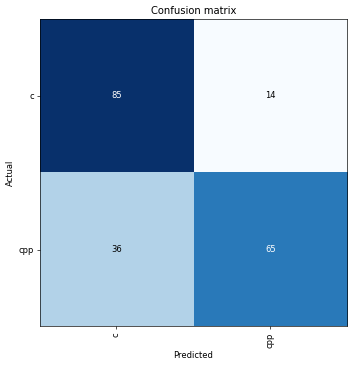

In [11]:
resNet.view_results()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8e809eb8-650a-4468-a096-2a2830a4a1e1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>